In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from arch import arch_model
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

Here are the Black-Scholes functions that will be used in our delta-hedging strategy.

In [2]:
def bs_call_delta(S0, K, sigma, t, r):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    return norm.cdf(d1)

ExecModel is our execution model, meaning that it takes a target number of hedge shares and simulates what would actually happen if we were to place that order in the market.

In [3]:
class ExecModel:
    def __init__(self, commission_per_share=0.005, spread_bps=1.0, extra_slip_bps=0.0, min_trade_shares=1, hysteresis_shares=5):
        self.comm = commission_per_share # broker fee per share traded
        self.spread_bps = spread_bps # width of the bid-ask spread in basis points
        self.slip_bps = extra_slip_bps # extra slippage, also in bps, to simulate impact or imperfect fills
        self.min_trade = min_trade_shares # We won't trade if the difference between target and current hedge is smaller than this.
        self.hysteresis = hysteresis_shares # If the gap between current shares and target shares is smaller than this, we don’t trade.
                                            # This prevents constant churn for tiny delta changes.

    def _bid_ask(self, mid):
        # creates an artificial bid-ask spread around the midpoint price
        spread = mid * (self.spread_bps / 1e4)  # bps to fraction
        bid = mid - spread/2
        ask = mid + spread/2
        return bid, ask

    def fill(self, current_shares, target_shares, mid_price):
        delta_shares = int(np.round(target_shares)) - int(current_shares)
        
        if abs(delta_shares) < max(self.hysteresis, self.min_trade):
            return 0, 0.0, 0.0  # no trade, no cash change, no fees

        bid, ask = self._bid_ask(mid_price)
        slip = mid_price * (self.slip_bps / 1e4)

        if delta_shares > 0:  # buying
            fill_px = ask + slip
        else:                  # selling
            fill_px = bid - slip

        trade_shares = delta_shares
        cash_change = -fill_px * trade_shares  # negative when buying, positive when selling
        fees = self.comm * abs(trade_shares)
        return trade_shares, cash_change, fees

Now we define our two volatility models. The first utilizes Black-Scholes exclusively, the other uses GARCH.

In [4]:
class RollingBSVol:
    def __init__(self, window=63, trading_days=252):
        self.window = window
        self.annual = trading_days

    def sigma_at(self, logret_series, t_idx):
        """
        Annualized rolling std using data up to t-1.
        t_idx is the integer representing the day that we are at in the backtest.
        """
        up_to = logret_series.iloc[:t_idx].tail(self.window) # computes the time series of daily log returns up to previous day
        if len(up_to) < max(10, self.window//3):  # need minimum data
            return np.nan
        return up_to.std() * np.sqrt(self.annual)

class RollingGARCHVol:
    def __init__(self, p=1, q=1, refit_every=5, lookback=504, trading_days=252):
        self.p, self.q = p, q # GARCH(p,q) parameters
        self.refit_every = refit_every # How often to refit the model
        self.lookback = lookback # How far back the training data goes
        self.annual = trading_days # For annualizing volatility
        self._last_fit_day = None # Keeps track of which day the model was last fit
        self._last_params = None # Keeps track of the parameters from the previous fitting

    def _fit(self, logrets):
        """
        Fits the model.
        """
        am = arch_model(logrets*100, vol='GARCH', p=self.p, q=self.q, dist='normal') # logrets*100 so that input is in percentages, not decimals
        res = am.fit(disp="off") # outputs are suppressed for cleanliness
        return res

    def sigma_at(self, logret_series, t_idx):
        """
        Forecasts next-day vol using data up to t-1.
        Refit every refit_every days on last 'lookback' returns.
        """
        if t_idx < 2:
            return np.nan
        
        # choose sample window
        end = t_idx
        start = max(0, end - self.lookback)
        sample = logret_series.iloc[start:end]

        # make sure we have enough lags to get a meaningful fit
        if len(sample) < max(50, self.p + self.q + 10):
            return np.nan

        # Check whether it is time to refit or not
        if (self._last_fit_day is None) or ((t_idx - self._last_fit_day) >= self.refit_every):
            res = self._fit(sample)
            self._last_params = res
            self._last_fit_day = t_idx
        else:
            res = self._last_params

        # One-step ahead forecast for day t (based on info through t-1)
        f = res.forecast(horizon=1, reindex=False)
        # variance for the last point in sample
        sigma_next = np.sqrt(f.variance.values[-1, 0]) / 100.0
        return sigma_next * np.sqrt(self.annual) # annualize the volatility because this is what Black-Scholes expects

Core: walk-forward hedging of one synthetic call from start_idx to expiry_idx

In [5]:
def hedge_one_lifecycle(
    px,                         # Series of close prices (Date index)
    open_px,                    # Series of next-day open prices (for execution)
    logrets,                    # Series of log returns aligned to px
    start_idx, maturity_days,
    strike_mult=1.0,            # ITM, ATM or OTM
    r=0.0,                      
    vol_model=None,             # the volatility model being used
    exec_model=None,            # ExecModel
    contract_multiplier=100,    # shares per option
    max_inventory=1000          # safety cap on shares
):
    N = len(px)
    expiry_idx = start_idx + maturity_days
    if expiry_idx >= N:
        return None  # not enough future data

    # Initialize option
    S0 = float(px.iloc[start_idx])
    K = S0 * strike_mult

    # State
    shares = 0
    cash = 0.0
    fees = 0.0
    records = []

    for t in range(start_idx + 1, expiry_idx + 1):
        # Time to expiry in years
        ttm = max(1e-6, (expiry_idx - t) / 252.0)

        # Estimate sigma using data up to t-1:
        sigma = vol_model.sigma_at(logrets, t)
        if np.isnan(sigma) or sigma <= 0:
            # no trade, just carry inventory value
            pass
        else:
            S_t = float(px.iloc[t-1])  # use last close for signal
            delta = bs_call_delta(S_t, K, sigma, ttm, r)
            target_shares = np.clip(delta * contract_multiplier, -max_inventory, max_inventory) # bound amount of shares by max_inventory

            mid = float(open_px.iloc[t]) if t < len(open_px) else float(px.iloc[t]) # reference price we build our bid/ask around
            d_shr, cash_chg, fee = exec_model.fill(shares, target_shares, mid)
            shares += d_shr
            cash += cash_chg
            fees += fee

        # Mark-to-market at close for reporting
        S_close = float(px.iloc[t])
        equity = shares * S_close
        dt = 1/252  # one trading day fraction of a year
        cash *= (1 + r * dt) # taking interest into account
        nav = cash + equity # net asset value

        records.append({
            "date": px.index[t],
            "S_close": S_close,
            "shares": shares,
            "cash": cash,
            "fees_cum": fees,
            "nav": nav
        })

    # Expiry settlement (use close at expiry)
    S_T = float(px.iloc[expiry_idx])
    payoff = max(S_T - K, 0.0) * 1.0

    # Force close hedge at expiry (ignore hysteresis so that all residual shares are cashed after the option has expired)
    if shares != 0:
        mid_T = S_T
        # bypass hysteresis by setting hysteresis=0 just for final trade
        tmp_exec = ExecModel(
            commission_per_share=exec_model.comm,
            spread_bps=exec_model.spread_bps,
            extra_slip_bps=exec_model.slip_bps,
            min_trade_shares=1,
            hysteresis_shares=0
        )
        d_shr, cash_chg, fee = tmp_exec.fill(shares, 0, mid_T)
        shares += d_shr
        cash += cash_chg
        fees += fee

    nav_final = cash + payoff
    df = pd.DataFrame(records).set_index("date")
    df.loc[df.index[-1], "nav_final_including_payoff"] = nav_final
    df.attrs["summary"] = {
        "S0": S0, "K": K, "expiry": px.index[expiry_idx],
        "payoff": payoff, "fees_total": fees, "final_nav": nav_final
    } # dictionary of summary info for each option
    return df

Walk-forward over many start dates and two models (BS rolling vol vs GARCH)

In [6]:
def walk_forward_delta_hedge(
    px_series, open_series, r=0.0,
    maturity_days_list=(21, 42, 63, 126),
    strike_multipliers=(0.9, 1.0, 1.1),
    bs_windows=(63,),
    garch_orders=((1,1),),
    refit_every=5,
    lookback=504,
    exec_kwargs=None
):
    exec_kwargs = exec_kwargs or {} # makes sure exec_kwargs is a dictionary
    results = []
    # Precompute log returns
    logrets = np.log(px_series.pct_change().add(1.0)).dropna()
    # Align open to px index so that open[t] is the next-day open relative to the px[t-1] signal)
    open_series = open_series.reindex(px_series.index).fillna(method="bfill")

    for maturity in maturity_days_list:
        for strike_mult in strike_multipliers:
            # Start a new option each day that has enough future data
            for start_idx in range(0, len(px_series) - maturity - 1):
                # BS rolling volatility first
                for w in bs_windows:
                    bsvol = RollingBSVol(window=w)
                    exec_model = ExecModel(**exec_kwargs)
                    df_bs = hedge_one_lifecycle(px_series, open_series, logrets, start_idx, maturity,
                                                strike_mult, r, bsvol, exec_model)
                    if df_bs is not None:
                        summ = df_bs.attrs["summary"]
                        results.append({
                            "model": f"BS_roll_w{w}",
                            "maturity_days": maturity,
                            "strike_mult": strike_mult,
                            "start_date": px_series.index[start_idx],
                            "expiry": summ["expiry"],
                            "S0": summ["S0"],
                            "K": summ["K"],
                            "payoff": summ["payoff"],
                            "fees_total": summ["fees_total"],
                            "final_nav": summ["final_nav"]
                        })
                # Then GARCH rolling volatility
                for (p,q) in garch_orders:
                    gvol = RollingGARCHVol(p=p, q=q, refit_every=refit_every, lookback=lookback)
                    exec_model = ExecModel(**exec_kwargs)
                    df_g = hedge_one_lifecycle(px_series, open_series, logrets, start_idx, maturity,
                                               strike_mult, r, gvol, exec_model)
                    if df_g is not None:
                        summ = df_g.attrs["summary"]
                        results.append({
                            "model": f"GARCH({p},{q})",
                            "maturity_days": maturity,
                            "strike_mult": strike_mult,
                            "start_date": px_series.index[start_idx],
                            "expiry": summ["expiry"],
                            "S0": summ["S0"],
                            "K": summ["K"],
                            "payoff": summ["payoff"],
                            "fees_total": summ["fees_total"],
                            "final_nav": summ["final_nav"]
                        })
    df_out = pd.DataFrame(results)
    if len(df_out):
        df_out["gross_pnl"] = df_out["final_nav"]  # nav is already net of hedge close with the payoff included
        df_out["net_pnl"] = df_out["gross_pnl"] - df_out["fees_total"]
        df_out["ret_bp_per_contract"] = df_out["net_pnl"] / 100.0  # Dividing by 100 returns dollars since 1 contract is 100 shares
    return df_out

These are the stocks that we will be working with and the window in which we are collecting the stock data.

In [7]:
tickers = ['AAPL', 'TSLA', 'F', 'HD', 'GM', 'SPY', 'QQQ']
start_date = '2025-01-01'
end_date   = '2025-10-11'
r = 0.0

Now we utilize the above functions to create the DataFrame df_liveish that house all of the Black-Scholes and GARCH hedging results.

In [8]:
raw = yf.download(tickers, interval='1d', start=start_date, end=end_date) # raw stock data
close = raw['Close']
open_  = raw['Open']

all_results = []
for tkr in tickers:
    px = close[tkr].dropna()
    op = open_[tkr].reindex(px.index).fillna(method='bfill')

    df_res = walk_forward_delta_hedge(
        px, op, r=r,
        maturity_days_list=(21, 42, 63),
        strike_multipliers=(0.9, 1.0, 1.1),
        bs_windows=(21, 63),
        garch_orders=((1,1),(2,1)),
        refit_every=5,
        lookback=504,
        exec_kwargs=dict(commission_per_share=0.005, spread_bps=1.0, extra_slip_bps=0.0,
                         min_trade_shares=1, hysteresis_shares=5)
    )
    if df_res is not None and len(df_res):
        df_res['ticker'] = tkr
        all_results.append(df_res)

df_liveish = pd.concat(all_results, ignore_index=True) # the list of DataFrames is concatenated
display(df_liveish.sort_values(['ticker','model','start_date']).head(20))

/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_2436/471246461.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, interval='1d', start=start_date, end=end_date) # raw stock data
[*********************100%***********************]  7 of 7 completed
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_2436/471246461.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  op = open_[tkr].reindex(px.index).fillna(method='bfill')
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_2436/533226459.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  open_series = open_series.reindex(px_series.index).fillna(method="bfill")
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_2436/471246461.py:8: FutureWarning: Series.fillna with 'met

,model,maturity_days,strike_mult,start_date,expiry,S0,K,payoff,fees_total,final_nav,gross_pnl,net_pnl,ret_bp_per_contract,ticker
0,BS_roll_w21,21,0.9,2025-01-02,2025-02-04,242.987427,218.688684,13.287817,1.12,-61.260227,-61.260227,-62.380227,-0.623802,AAPL
688,BS_roll_w21,21,1.0,2025-01-02,2025-02-04,242.987427,242.987427,0.000000,0.37,-0.220990,-0.220990,-0.590990,-0.005910,AAPL
1376,BS_roll_w21,21,1.1,2025-01-02,2025-02-04,242.987427,267.286169,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,AAPL
2064,BS_roll_w21,42,0.9,2025-01-02,2025-03-06,242.987427,218.688684,16.066702,1.26,25.565094,25.565094,24.305094,0.243051,AAPL
2668,BS_roll_w21,42,1.0,2025-01-02,2025-03-06,242.987427,242.987427,0.000000,1.19,-249.560117,-249.560117,-250.750117,-2.507501,AAPL
3272,BS_roll_w21,42,1.1,2025-01-02,2025-03-06,242.987427,267.286169,0.000000,0.18,-20.778231,-20.778231,-20.958231,-0.209582,AAPL
3876,BS_roll_w21,63,0.9,2025-01-02,2025-04-04,242.987427,218.688684,0.000000,1.98,-3603.794256,-3603.794256,-3605.774256,-36.057743,AAPL
4396,BS_roll_w21,63,1.0,2025-01-02,2025-04-04,242.987427,242.987427,0.000000,1.00,-801.836757,-801.836757,-802.836757,-8.028368,AAPL
4916,BS_roll_w21,63,1.1,2025-01-02,2025-04-04,242.987427,267.286169,0.000000,0.32,-158.822746,-158.822746,-159.142746,-1.591427,AAPL
4,BS_roll_w21,21,0.9,2025-01-03,2025-02-05,242.499161,218.249245,13.398445,1.11,-94.962721,-94.962721,-96.072721,-0.960727,AAPL


# Visualizations

Hedge Performance vs Benchmark

<Axes: xlabel='net_pnl', ylabel='Density'>

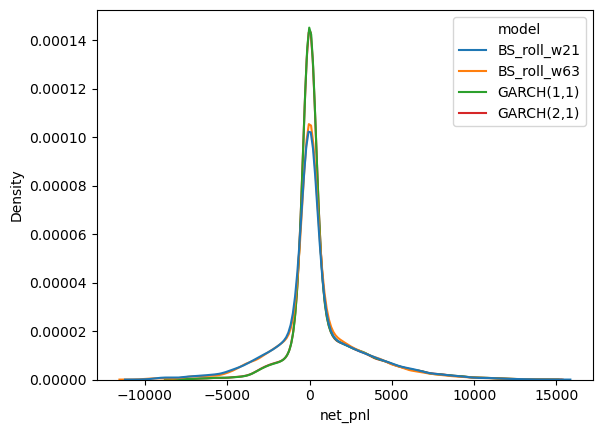

In [10]:
sns.kdeplot(data=df_liveish, x="net_pnl", hue="model")

Cumulative profit and loss over time of each ticker.

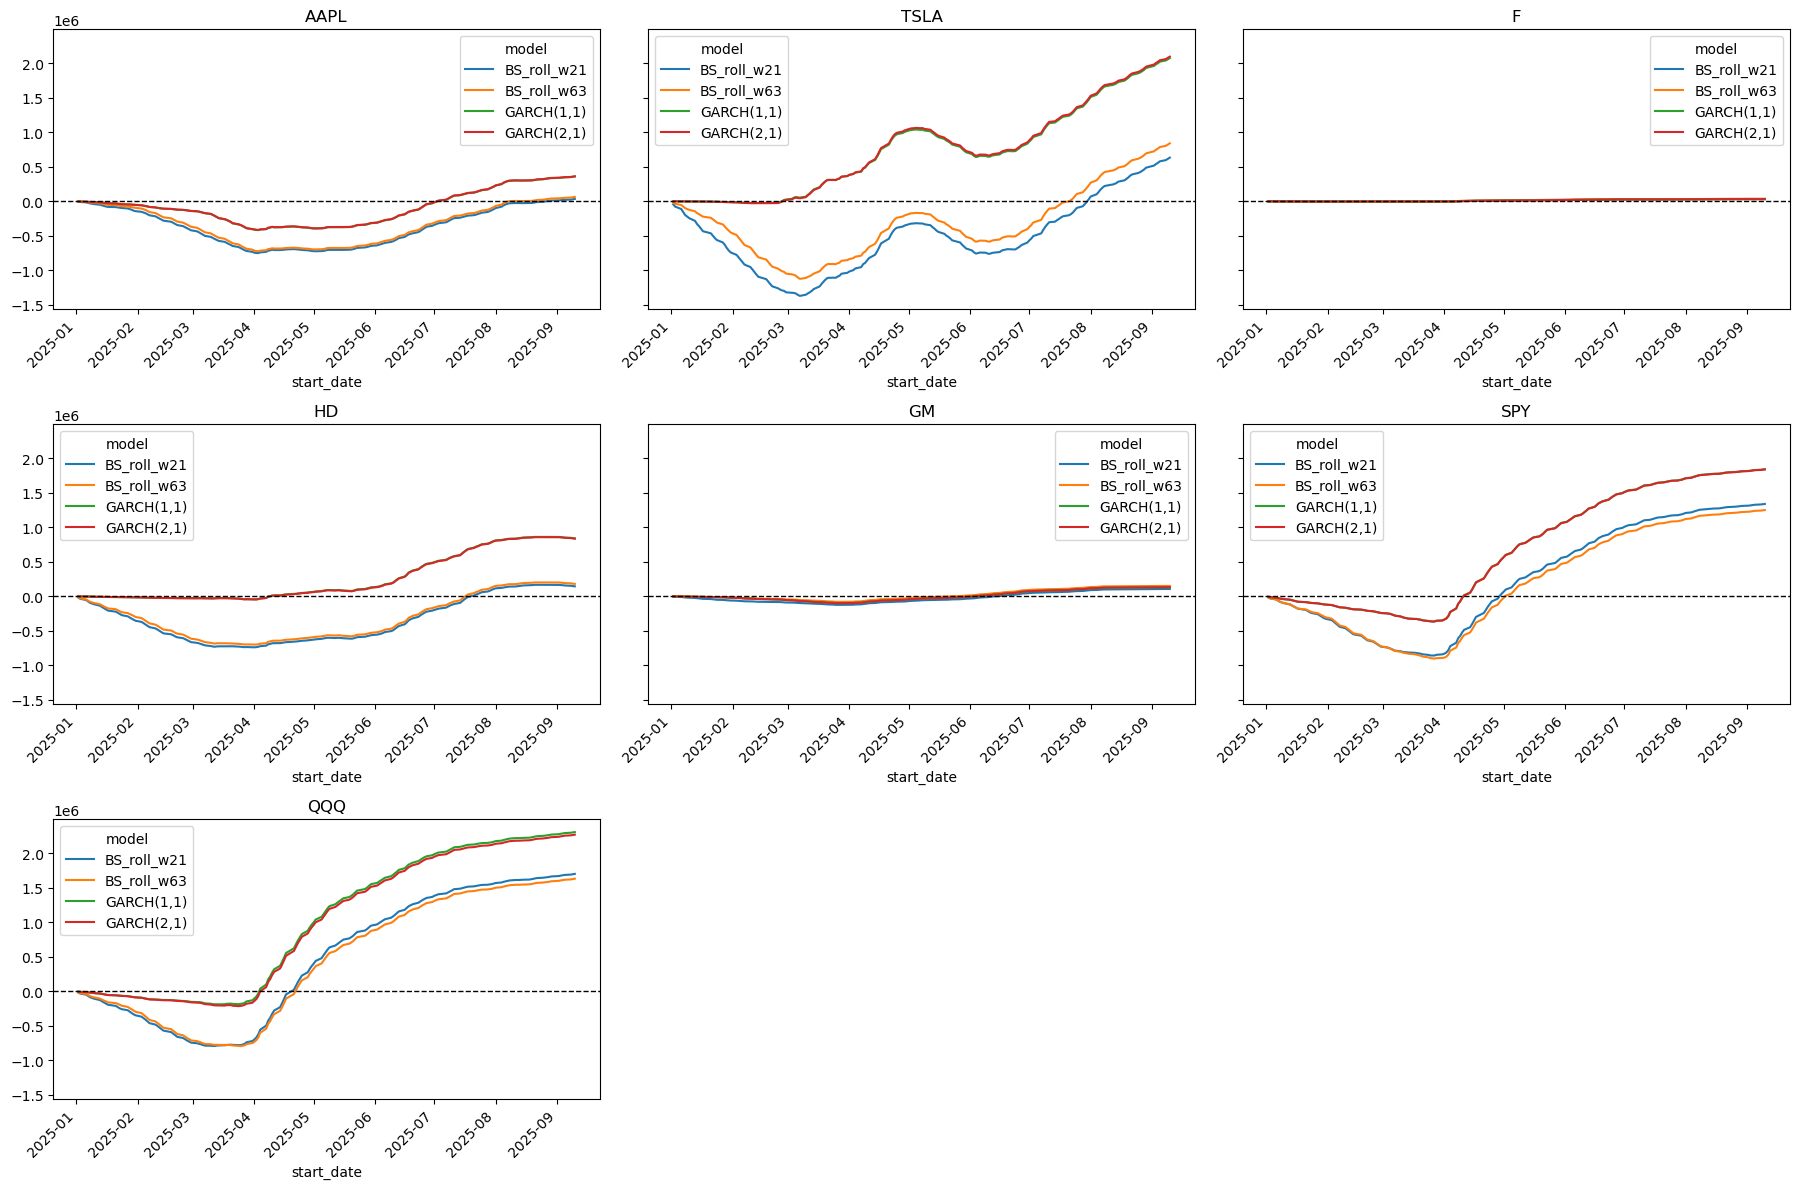

In [18]:
ncols = 3   # 3 plots per row
nrows = -(-len(tickers) // ncols)  # ceiling division

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(6*ncols, 4*nrows),   # scale size to grid
    sharey=True
)

axes = axes.flatten()  # make iterable
for ax, tkr in zip(axes, tickers):
    df_tkr = df_liveish[df_liveish.ticker == tkr]
    (
        df_tkr.groupby(["start_date","model"])["net_pnl"]
        .sum()
        .groupby("model")
        .cumsum()
        .unstack()
        .plot(ax=ax)
    )
    ax.set_title(tkr)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.tick_params(axis='x', rotation=45)

# Hide any unused axes if tickers don't fill grid
for ax in axes[len(tickers):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


Boxplots of net P&L grouped by maturity_days and strike_mult.

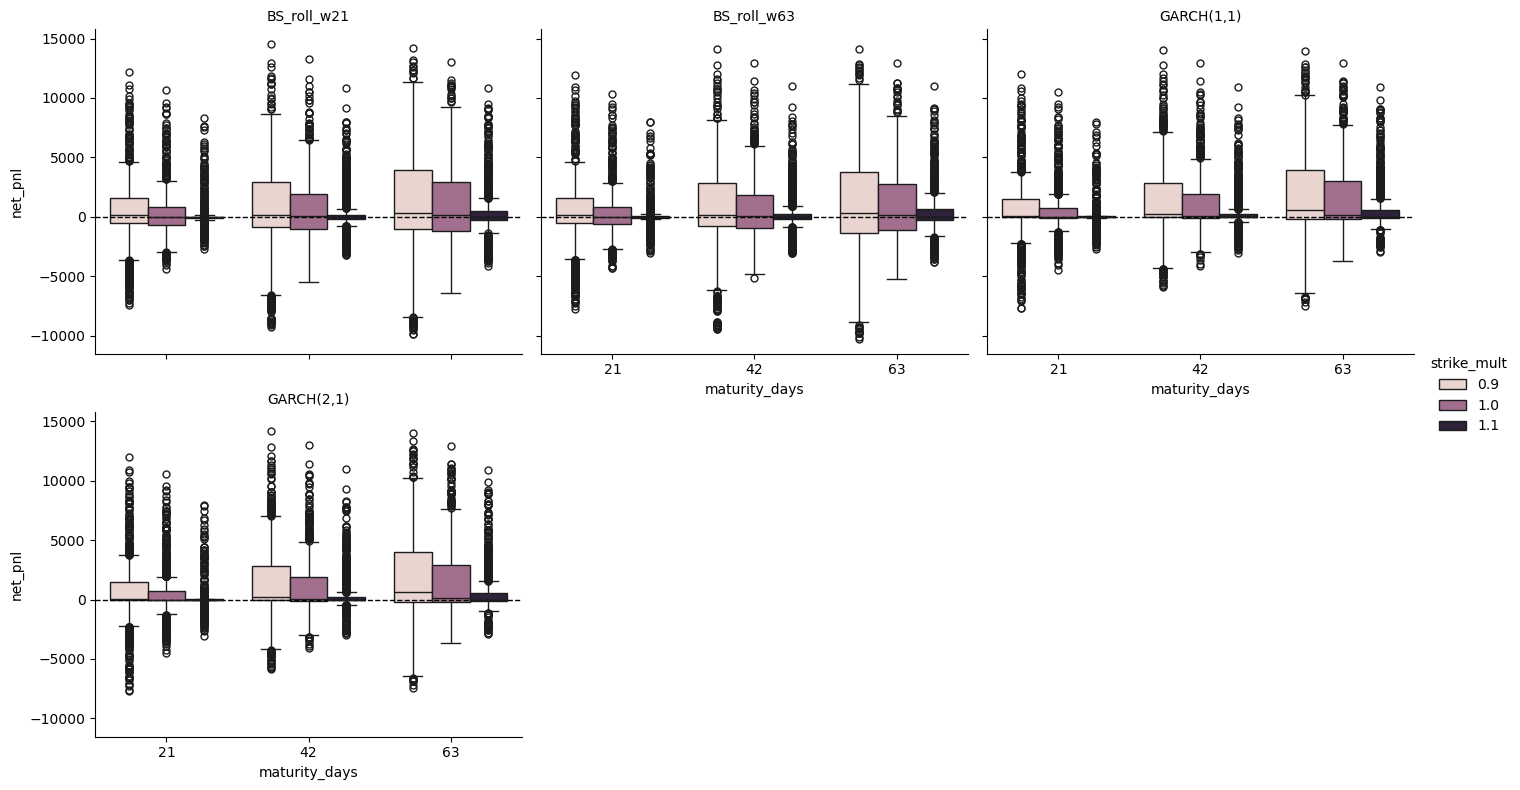

In [19]:
g = sns.catplot(
    data=df_liveish,
    x="maturity_days", y="net_pnl", hue="strike_mult",
    kind="box", col="model", col_wrap=3,
    height=4, aspect=1.2
)
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
plt.show()

Bar chart of average fees as % of gross P&L per model.

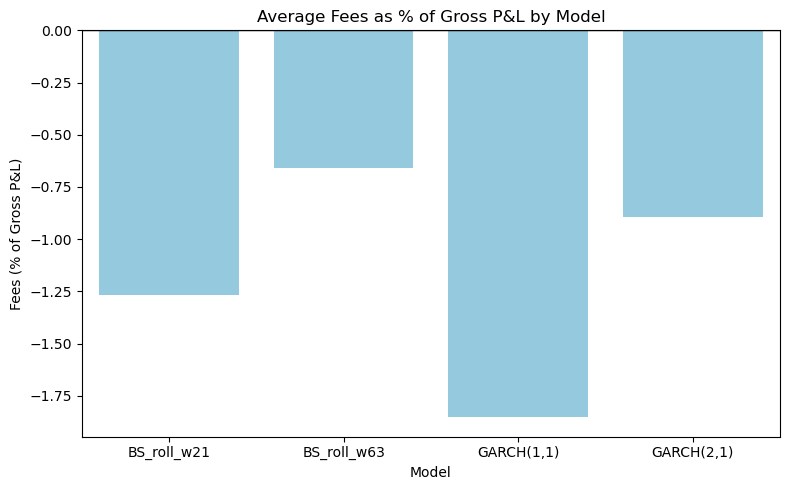

In [20]:
# Compute fees as % of gross P&L
df_liveish["fees_pct"] = 100 * df_liveish["fees_total"] / df_liveish["gross_pnl"]

# Group by model and take the mean
fees_summary = df_liveish.groupby("model")["fees_pct"].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=fees_summary, x="model", y="fees_pct", color="skyblue")
plt.title("Average Fees as % of Gross P&L by Model")
plt.ylabel("Fees (% of Gross P&L)")
plt.xlabel("Model")
plt.axhline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


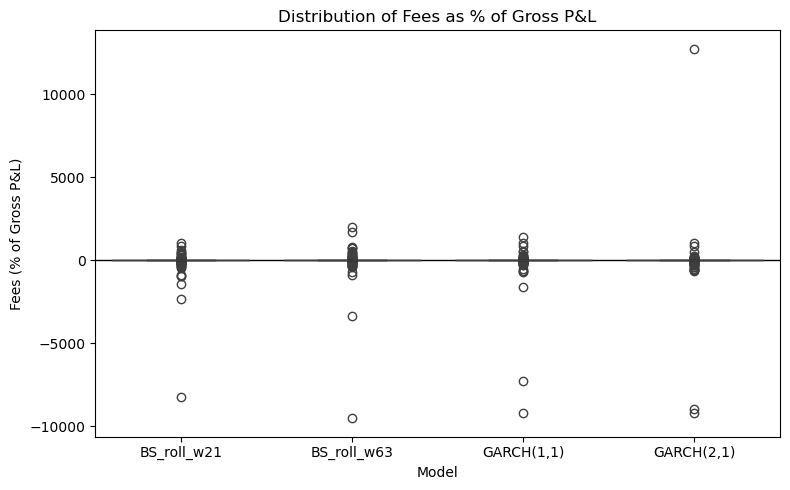

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_liveish, x="model", y="fees_pct")
plt.title("Distribution of Fees as % of Gross P&L")
plt.ylabel("Fees (% of Gross P&L)")
plt.xlabel("Model")
plt.axhline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


Time series of hedging error (final_nav - payoff) for BS vs. GARCH.

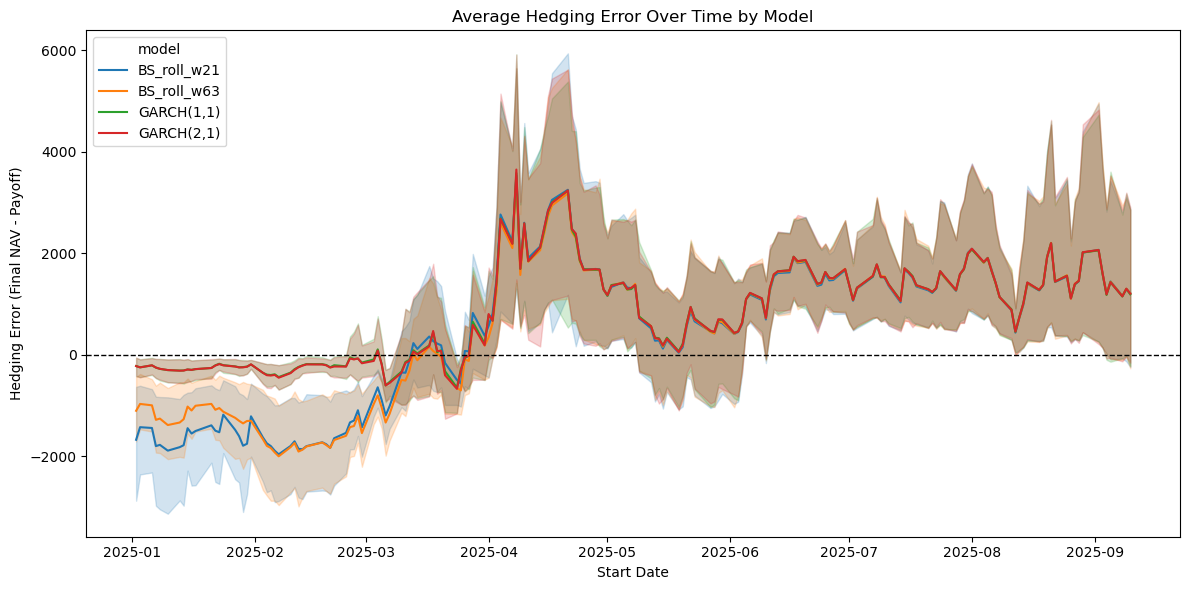

In [ ]:
# Compute hedging error per row
df_liveish["hedging_error"] = df_liveish["final_nav"] - df_liveish["payoff"]

# Aggregate by start_date and model (average error across tickers/strikes/maturities)
df_err = (
    df_liveish.groupby(["start_date","ticker","model"])["hedging_error"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_err,
    x="start_date",
    y="hedging_error",
    hue="model"
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Hedging Error Over Time by Model")
plt.ylabel("Hedging Error (Final NAV - Payoff)")
plt.xlabel("Start Date")
plt.tight_layout()
plt.show()


Heatmap of average P&L by (maturity_days × strike_mult).

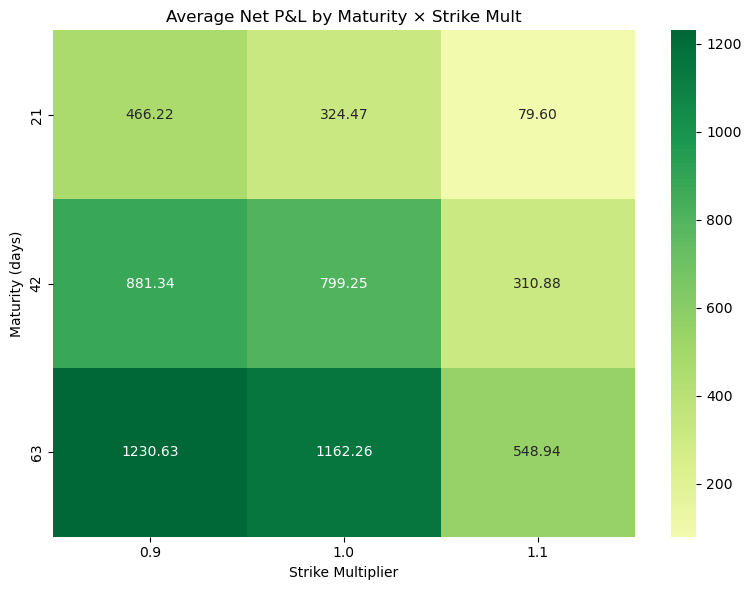

In [30]:
# Compute average net P&L grouped by maturity_days and strike_mult
heatmap_data = (
    df_liveish.groupby(["maturity_days","strike_mult"])["net_pnl"]
    .mean()
    .unstack()   # makes strike_mult the columns
)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".2f", cmap="RdYlGn", center=0
)
plt.title("Average Net P&L by Maturity × Strike Mult")
plt.xlabel("Strike Multiplier")
plt.ylabel("Maturity (days)")
plt.tight_layout()
plt.show()
